# Computer Vision: Plants Classification

This classification is based on the **Plant Seedlings Dataset**, which contains images of approximately 960 unique plants belonging to 12 species at several growth stages, with a resolution of about 10 pixels per mm of annotated RGB images.

The dataset includes the following species:


|English     |Latin               |EPPO|
|:-----------|:-------------------|:---|
|Maize       |Zea mays L.         |ZEAMX|
|Common wheat|Triticum aestivum L.|TRZAX|
|Sugar beet|Beta vulgaris var. altissima|BEAVA|
|Scentless Mayweed|Matricaria perforata Mérat|MATIN|
|Common Chickweed|Stellaria media|STEME|
|Shepherd’s Purse|Capsella bursa-pastoris|CAPBP|
|Cleavers|Galium aparine L.|GALAP|
|Charlock|Sinapis arvensis L.|SINAR|
|Fat Hen|Chenopodium album L.|CHEAL|
|Small-flowered Cranesbill|Geranium pusillum|GERSS|
|Black-grass|Alopecurus myosuroides|ALOMY|
|Loose Silky-bent|Apera spica-venti|APESV|



#### Basics:
* CNNs: Convolutional Neural Networks. It has been the technique with greater success in the last years
* ReLUS: Neurons with nonlinearity as Rectified Linear Units as they train faster than for example tanh units and they do not require input normalization to prevent saturation, although local normalization still helps generalization. Response normalization helps to reduce the final error.

#### Reducing Overfitting:
* Data Augmentation: 
    - Applying transformations (translation, rotations, zooming...) having the dataset multiplied by factors of 2048.
    - PCA performed on the RGB values, altering the intensities of the channels and adding to each image multiples of the principal componenets found with magnitues proportional to the corresponding eigenvalues itmes a random variables (from a Gaussian with mean 0 and st dev 01)
* Dropout: Combining predictions of many models is very effective to reduce errors but it's way too expensive for big neural networks that take days to train. Dropouts sets to zero the output of each hidden node with a probability of 0.5 and this way the drop out neurons do not contribute to the forward pass nor they participate on the back-propagation. So every time the NN presents a different architecture but all of them share weights. This technique reduces co-adaptations of neurons as they cannot rely on the presence of other particular neurons and they are forced to learn more robust features.

#### Some Details extracted from the papers:
- Stochastic gradient descent for training with batches of 128, momentum of 0.9 and weight decay of 0.0005 which was not merely a regularizer but it reduces as well the training error.
- The initialization was done with a Gaussian distribution with st. dev. 0.01
- The learning rate at 0.01 and reduced three times prior to termination.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext watermark
%watermark -v -m -p numpy,pandas,sklearn,tensorflow -g

import re
import os
import sys
from time import time
import pickle
import pathlib
import itertools
from math import ceil
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import swifter
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import watermark

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

np.random.seed(42)

CPython 3.7.3
IPython 7.8.0

numpy 1.17.3
pandas 0.25.1
sklearn 0.21.3
tensorflow 2.0.0

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.0.0
machine    : x86_64
processor  : i386
CPU cores  : 16
interpreter: 64bit
Git hash   : 529455e71c3fbe1904341a957cbe9f1267d1c067


In [2]:
# Libraries specific of Deep learning and images
import imageio
from skimage.transform import resize as imresize
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

import tensorflow as tf2
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.layers import Input, Activation, Maximum, ZeroPadding2D, concatenate, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
sys.path.append(os.pardir)
from src.tsne import tsne

1. **Introduction**
<br>

2. **Data preparation**
    - 2.1 Load data
    - 2.2 Check for null and missing values
    - 2.3 Normalization
    - 2.4 Reshape
    - 2.5 Label encoding


3. **CNN**
    - 3.1 Define the model
    - 3.2 Set the optimizer and annealer
    - 3.3 Data augmentation


4. **Model Evaluation**
    - 4.1 Training and validation curves


5. **Prediction**
    - 5.1 Predict samples
    - 5.2 Confusion matrix

## 1. Introduction

This is a 5 layers Sequential CNN build with **Keras API** and trained on MNIST dataset.

The model achieves a very high accuracy (99.52%) with this CNN trained in 1h25min on a laptop (MacBook Pro Intel Core i9). If you have a GPU at hand you can use tensorflow-gpu with keras. Computation will be much much faster!!!

Initially the number of epochs 3 but to achive the highest accurary you can set it to 30 epochs.

## 2. Data Preparation
### 2.1 Load data

The data is located at subfolders with the classes names in each parent folder.

In [4]:
PLANT_CLASSES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 
                 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 
                 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
CLASSES_DICT_NAMES = {name: k for k, name in zip(range(len(PLANT_CLASSES)), PLANT_CLASSES)}
CLASSES_DICT_NUM = {k: name for k, name in zip(range(len(PLANT_CLASSES)), PLANT_CLASSES)}
NUM_CATEGORIES = len(PLANT_CLASSES)

# INFO_DF = "./data/plants/info.gz"
# DATA_DF = "./data/plants/data.gz"
DF_PART1 = "./data/plants/plants_part1.gz"
DF_PART2 = "./data/plants/plants_part2.gz"
DF_PART3 = "./data/plants/plants_part3.gz"

DATA_FOLDER = "./data/plants"
RESHAPE_SIZE = (65, 65, 3)
RANDOM_STATE = 42

CLASSES_DICT_NAMES

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

In [5]:
# Build some abbreviations from the list
def get_abbreviation(name):
    split_regex = re.compile("[ \-,;:]")
    splitted = split_regex.split(name)
    if len(splitted) == 1:
        return splitted[0][:2].upper()
    else:
        return "".join([k[0].upper() for k in splitted])

ABBREVIATIONS = [get_abbreviation(m) for m in PLANT_CLASSES]
print(f"Abbreviations: {ABBREVIATIONS}")

Abbreviations: ['BG', 'CH', 'CL', 'CC', 'CW', 'FH', 'LSB', 'MA', 'SM', 'SP', 'SFC', 'SB']


In [6]:
df_p1 = pd.read_csv(DF_PART1)
df_p2 = pd.read_csv(DF_PART2)
df_p3 = pd.read_csv(DF_PART3)

df = pd.concat([df_p1, df_p2, df_p3], axis=0)
df.shape
df.columns[:10]

Index(['label', 'class', '0', '1', '2', '3', '4', '5', '6', '7'], dtype='object')

Count per category:
Loose Silky-bent             564
Common Chickweed             540
Scentless Mayweed            439
Small-flowered Cranesbill    431
Fat Hen                      422
Sugar beet                   355
Charlock                     347
Black-grass                  241
Cleavers                     224
Shepherd’s Purse             203
Maize                        197
Common wheat                 191
Name: class, dtype: int64


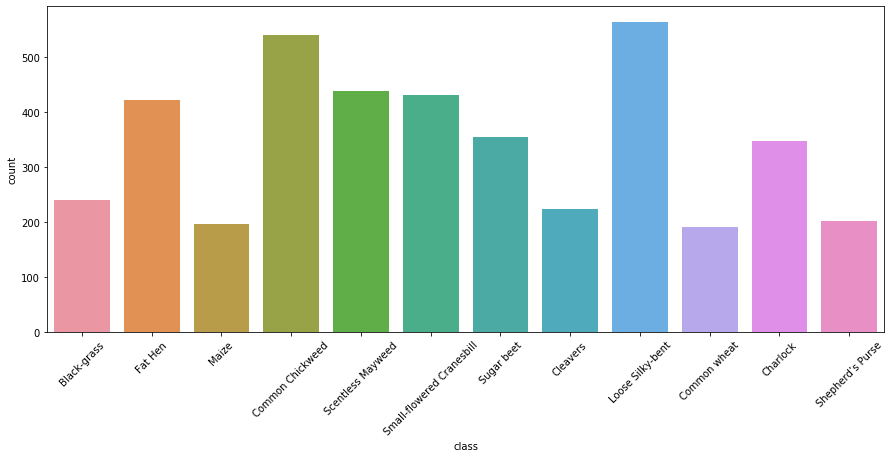

In [7]:
plt.figure(figsize=(15, 6))
plt.xticks(rotation=45)
g = sns.countplot(df["class"])

print(f"Count per category:\n{df['class'].value_counts()}");

In [8]:
count_mean = df['class'].value_counts().mean()
upper_lvl = 100 * (df['class'].value_counts().max() - count_mean)/count_mean
lower_lvl = 100 * (df['class'].value_counts().min() - count_mean)/count_mean
print(f"Difference in the upper range: {upper_lvl:.1f}")
print(f"Difference in the lower range: {lower_lvl:.1f}")

Difference in the upper range: 62.9
Difference in the lower range: -44.8


Clearly we have an imbalance dataset. The difference in the counts across the different classes is quite high and the data needs to be balance in order to get the best results.

It's important to verify that we have a balanced distribution of cases across all the categories to avoid having a model with bias because of training in a few specific categories. If that happens the model will likely perform poorly in a generalized dataset that may not have the same bias.

Some techniques we may want to consider includes:
- **Stratified sampling**
- **Cost-sensitive learning**
- **SMOTE** algorithm: stands for Synthetic Minority Over-sampling Technique and it uses a k-nearest neighbours approach to exclude members of the majority class while in a similar way creating synthetic examples of a minority class.
- **ROSE** algorithm: tries to create estimates of the underlying distributions of the two classes using a smoothed bootstrap approach and then sample the classes.
- **ADASYN**

The following steps will consist on:
- Updating the class names to a numeric value
- Solve the unequal distribution of samples
- Create a train and test datasets

In [9]:
# Transform the class into a numeric value
df['class'] = df['class'].swifter.apply(lambda x: CLASSES_DICT_NAMES[x.replace("’", "")])

/Users/josesanz/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### 2.2 Check for null and missing values

In [10]:
# Check the data:
print(f"Any missing values in the dataset: {np.isnan(df['class']).any()}")

Any missing values in the dataset: False


In this case we don't have missing values, otherwise we may have to drop the entries that won't help to train our model.

### 2.3 Normalization

We normalize the data if required which helps to achieve a faster convergence. In this case it's already in the [0..1] range so theres is no need.

### 2.4 Reshape

Load images in the desired shape of 3D matrices.

In [11]:
# Extract the info (label and class) from the images data
df_info = df[["class"]]
df.drop(labels=["label", "class"], axis=1, inplace=True)

# Apply the shape required
df = df.values.reshape(-1, *RESHAPE_SIZE)

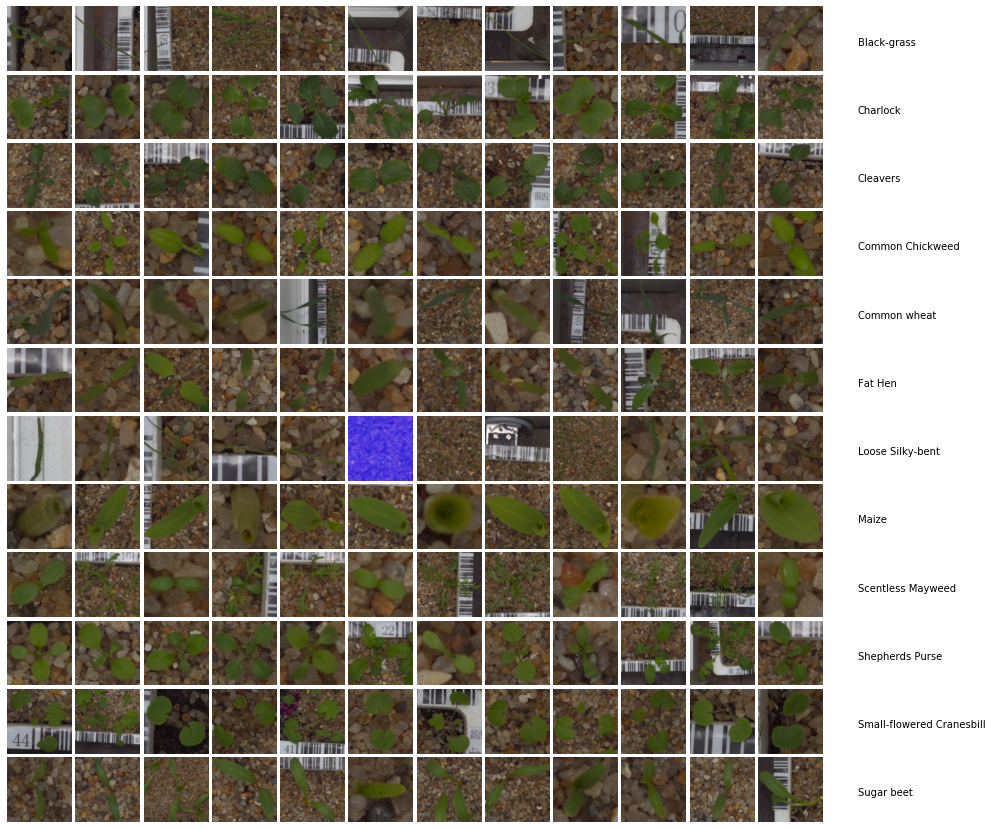

In [12]:
# Examples of the data
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)
i = 0
for category, category_id in CLASSES_DICT_NAMES.items():
    for img_data in df[df_info["class"]==category_id][:NUM_CATEGORIES]:
        ax = grid[i]
        ax.imshow(img_data)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(100, 35, category, verticalalignment='center')
        i += 1
fig.set_figheight(15)
fig.set_figwidth(15)
# plt.show();

There is nothing much that can be understood from the images (unless you are an expert in the area) as all the images look pretty much the same to me. So instead I want to use a visualization technique called **t-Distributed Stochastic Neighbor Embedding (t-SNE)** to plot the distribution of the images.

In [22]:
Y = tsne(df, final_dims=2, initial_dims=100, perplexity=20.0)

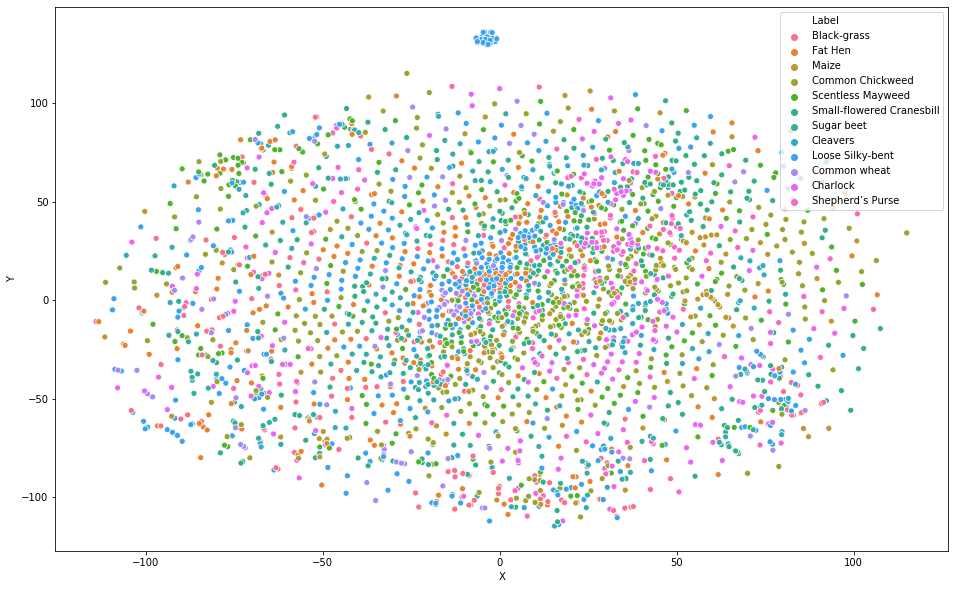

In [25]:
tsne_df = pd.DataFrame({"X": Y[:,0], "Y": Y[:,1], "Label": df_info["class"]})
plt.figure(figsize=(16, 10))
sns.scatterplot(x="X", y="Y", data=tsne_df, hue="Label");

Looking closely again, we can hardly see the difference in the classes. At this point is important to understand if the data is very difficult to distinguish only for humans or if it is difficult for the machine learning model too. To understand this we could do a basic benchmark or a simple model vs a complex model to understand if we are overfitting/underfitting the dataset on the given model.

### 2.5 Augmentation of lower count labels

In [13]:
def image_generator():
    return ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range=360,                   # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15,                    # Randomly zoom image 
        width_shift_range=0.15,               # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,              # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,                 # randomly flip images
        vertical_flip=True)                   # randomly flip images

def equalizer_augmentation(images, labels, label, batch=64):
    total_count = labels[label].value_counts(sort=True)
    higher_count = total_count.values[0]
    
    fill_info = {}
    for idx, count in zip(total_count.index[1:], total_count.values[1:]):
        fill_info[idx] = higher_count - count
    
    images_generated = None
    labels_generated = None
    datagen = image_generator()
    datagen.fit(images)
    
    for key, val in fill_info.items():
        print(f"Generating {val} images for label {key}")
        selection = labels[labels['class'] == key]
        ngen = val if val <= batch else batch
        gen = datagen.flow(images[selection.index], np.full(selection.shape[0], key), batch_size=ngen)

        counter = 0
        while counter < val:
            if val - counter < batch:
                gen = datagen.flow(images[selection.index],
                                   np.full(selection.shape[0], key),
                                   batch_size=(val - counter))
                
            new_images, new_labels = next(gen)
            if images_generated is None:
                images_generated = new_images
                labels_generated = new_labels
            else:
                images_generated = np.concatenate([images_generated, new_images], axis=0)
                labels_generated = np.concatenate([labels_generated, new_labels])
            counter += batch
            
    total_images = np.concatenate([images, images_generated], axis=0)
    total_labels = np.concatenate([labels['class'].values, labels_generated], axis=0)
    return total_images, total_labels

In [14]:
images_generated, labels_generated = equalizer_augmentation(df, df_info, 'class')

Generating 24 images for label 3
Generating 125 images for label 8
Generating 133 images for label 10
Generating 142 images for label 5
Generating 209 images for label 11
Generating 217 images for label 1
Generating 323 images for label 0
Generating 340 images for label 2
Generating 361 images for label 9
Generating 367 images for label 7
Generating 373 images for label 4


Now we validate the distribution of the dataset

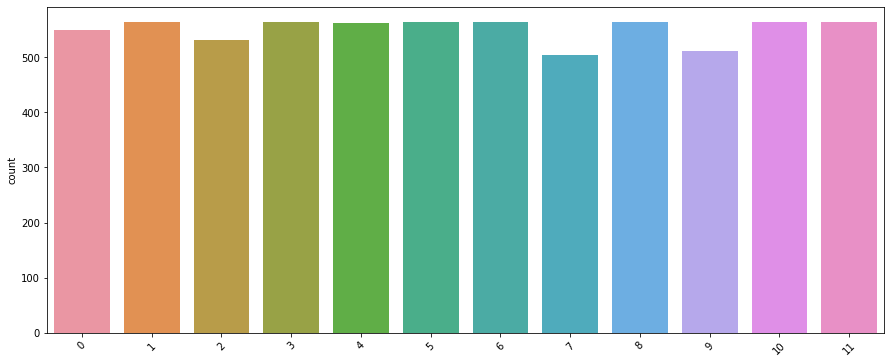

In [15]:
plt.figure(figsize=(15, 6))
plt.xticks(rotation=45)
g = sns.countplot(labels_generated)

### 2.5 Label encoding

In [16]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
n_unique = np.unique(labels_generated).size
labels_encoded = to_categorical(labels_generated, num_classes=n_unique)

### 2.6 Split training and valdiation set

In [17]:
X_tr, X_te, Y_tr, Y_te = train_test_split(
        images_generated, labels_encoded, 
        test_size=0.15, random_state=RANDOM_STATE)

Be carefull with some unbalanced dataset where a simple random split could cause inaccurate evaluation during the validation.

To avoid that, you could use stratify=True option in train_test_split function (only for >=0.17 sklearn versions).

It may be useful as well to understand the distribution of the gradation of the color layer that we have. Humans are limited and we see 100 levels of gradation of a single color (in this case, white/grey/black) and even fewer with the limitations of a computer display, but we may have images with up to 2^16 == 65536 levels in a 16 bit image and the CNN won't have problems seeing those differences as it takes as input floating point data.

For human purposes we may apply windowing and get 3x levels by using 3 channel image with different windows in each channel.

On the other hand this doesn't mean that we can ignore scaling entirely for the CNN as having well-scaled inputs is really important in getting good results from your NN. That means we want to see a good mix of values throughout the range of our data (e.g. something having approximately a normal or uniform distribution).

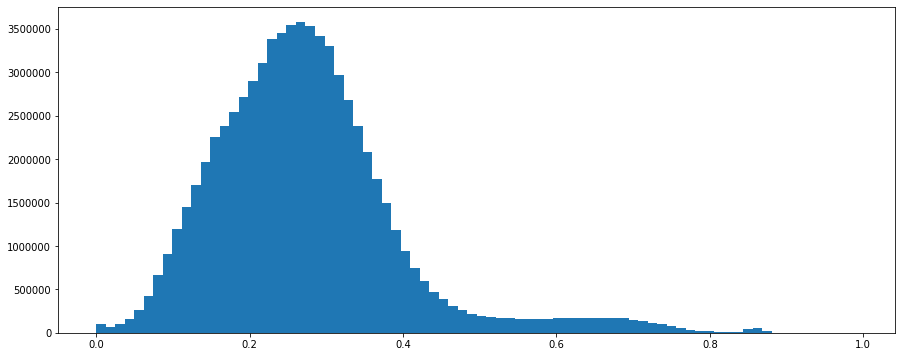

In [18]:
px = X_tr.flatten()
plt.figure(figsize=(15, 6))
plt.hist(px, bins=80);

As the graph shows, we don't have that. We have a Positive Skewed Distribution that we could model as a log-normal or Galton distribution, with a long tail to the right. But that's OK, we can normalize this using a simple scaling of the pixel values using a non-linear mapping designed to give us an equal number of pixels in each range. To do that we first split the range of pixel values into groups, such that each group has around the same number of pixels.

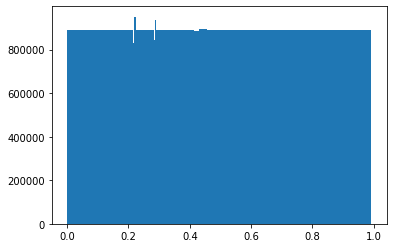

In [19]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

# Calculate the bins. In this case as most points are just zero there is not much we can do.
n, bins, patches = plt.hist(px, histedges_equalN(px, 80))

As we see if we apply this bins we obtain a nice uniform distribution as we have now a similar number of values in all bins.

Now we just need a function to scale the pixels evenly using these bins and if we just join the previous bins with line segments, we obtain:

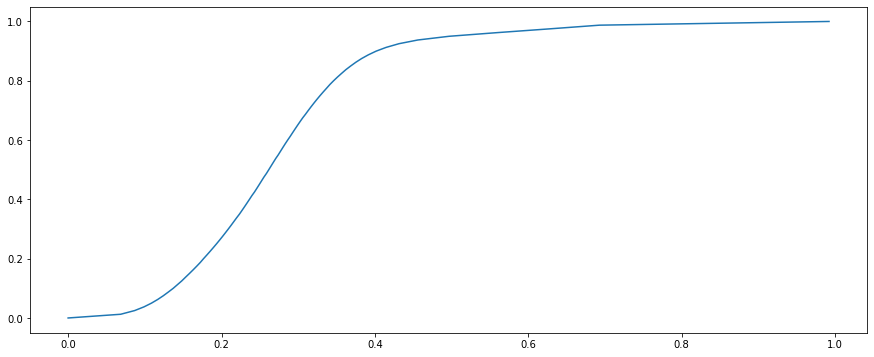

In [20]:
plt.figure(figsize=(15, 6))
plt.plot(bins, np.linspace(0, 1, len(bins)))

## 3. CNN
### 3.1 Define the model

In tensorflow 2.0 Keras is already included as its Sequential API is really easy to use. With the Sequential API you just have just to add one layer at a time starting from the input.

First is the **convolutional (Conv2D) layer**, a set of learnable filters. I choosed to set 32 filters for the two firsts conv2D layers and 64 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the **pooling (MaxPool2D) layer**. This layer simply acts as a downsampling filter by looking at the 2 neighboring pixels and picking the maximal value. This technique is used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size. The highest the pooling dimension, more the downsampling is important.

Combining convolutional and pooling layers CNN are able to combine local features and learn more global features of the image.

**Dropout** is a regularization method, where a proportion of nodes in the layer are randomly set to zero with 0.5 probability for each training sample. This forces the network to learn features in a distributed way and the NN have to learn independenly from each other. This technique also improves generalization and reduces the overfitting.

**ReLU** is the rectifier, and activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

The **Flatten layer** is used to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

And finally two fully-connected **(Dense) layers** which is just an Artificial Neural Networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs  the distribution of probability for each class.

In [21]:
# Set the CNN model with architechture:
#    In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

def create_CNN_model():
    model = Sequential()


    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding="Same", 
                     activation="relu", input_shape = RESHAPE_SIZE))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding="Same",
                     activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))


    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="Same",
                     activation ="relu"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="Same",
                     activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))


    # Combine all local features into 1D vector
    model.add(Flatten())
    # Classifier
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(12, activation="softmax"))
    return model

### 3.2 Set the optimizer and annealer

Now we need to set up a **score function** a **loss function** and an **optimisation algorithm**.

We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the ***"categorical_crossentropy"***.

The most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons ...) in order to minimise the loss. RMSprop (with default values) is a very effective optimizer. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate. We could also have used Stochastic Gradient Descent ('sgd') optimizer, but it is slower than RMSprop.

The metric function "accuracy" is used is to evaluate the performance our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In [22]:
# Define the optimizer
optimizer_RMS = RMSprop(lr=0.0015, rho=0.9, epsilon=1e-08, decay=0.0)
optimizer_Adam = Adam(lr=2 * 1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# Compile the model
model = create_CNN_model()
model.compile(optimizer=optimizer_RMS, 
              loss = "categorical_crossentropy", 
              metrics=["accuracy"])

# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 65, 65, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 65, 65, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0

In order to make the optimizer converge faster and closest to the global minimum of the loss function, we use an **annealing method** of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.

To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, we choose to reduce the LR by half if the accuracy is not improved after 3 epochs.

In [23]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
# To save with epochs number: "./weights.{epoch:02d}.hdf5"
CNN_MODEL = "./models/model1_CNN.hdf5"
model_save = ModelCheckpoint(CNN_MODEL, 
                             save_best_only=True,
                             save_weights_only=True,
                             verbose=1)

model_callbacks = [learning_rate_reduction, model_save]

#### From previous model... (optional)

If we have previously saved a model with the same architecture, we can just load the weights into the new instance.  a *SavedModel* is a directory containing serialized signatures and the state needed to run them, including variable values and vocabularies. The folder will contain:
- saved_model.pb: stores the actual TensorFLow program or model and a set of named signatures, each identifying a function that accepts tensor inputs and produces tensor outputs.
- variables: contains a standard training checkpoint.
- assets: contains files used by the TensorFlow graph, for example text files used to initialize vocabulary tables.

We choose the checkpoint from which we want to load the weights and we'll have our model back!

If we are in a production environment we'll be better off using [**TensorFlow Serving** ](https://github.com/tensorflow/serving/blob/master/tensorflow_serving/g3doc/tutorials/Serving_REST_simple.ipynb)

```nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=mobilenet \
  --model_base_path="/tmp/mobilenet" >server.log 2>&1```

In [24]:
# CHECKPOINT_PATH = "./models/model1_CNN_Adam.hdf5"
# # build and compile and then
# model.load_weights(CHECKPOINT_PATH)  # At this moment we don't pre-load the model

### 3.3 Data augmentation

In order to **avoid overfitting** we need to expand artificially our handwritten digit dataset. We can make the existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

Some operations we can perform while keeping the same labels, include:

- Translation
- Rotation
- Zooming
- Random crops
- Grayscales
- Color jitters
- Horizontal flips
- Vertical flips

This way we can triple or more the number of training examples and create a very robust model. This is an important step as it provides a relevant improvement to the model:

- Without data augmentation: accuracy of 98.79%
- With data augmentation:  99.52% of accuracy

In [25]:
# %%time
# Without data augmentation
# trained_model_no_aug = model.fit(X_tr, Y_tr, batch_size=batch_size, epochs=epochs, 
#                                  validation_data=(X_te, Y_te), verbose=2)

<img src="./fig/CV_Classif_Plants_no_augmentation.png" alt="RGB explination" width="800"/>

For the data augmentation:

- Randomly rotate some training images by 10 degrees
- Randomly Zoom by 10%
- Randomly shift images horizontally by 10% of the width
- Randomly shift images vertically by 10% of the height
- Not vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

If you set the *steps_per_epoch* to fit *n_samples / batch_size*, where n_samples is the total number of training data you have (i.e. 1k) then in each epoch, each training sample is augmented only one time (therefore 1k transformed images will generated in each epoch)

In [27]:
# With data augmentation to prevent overfitting
datagen = ImageDataGenerator(
    featurewise_center=False,             # set input mean to 0 over the dataset
    samplewise_center=False,              # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,   # divide each input by its std
    zca_whitening=False,                  # apply ZCA whitening
    rotation_range=10,                    # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1,                     # Randomly zoom image 
    width_shift_range=0.1,                # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,               # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,                # randomly flip images
    vertical_flip=False)                  # randomly flip images

datagen.fit(X_tr)

In [28]:
%%time
# Fit the model
epochs = 2            # Turn epochs to 55 to get 0.8 accuracy
batch_size = 64
history = model.fit_generator(datagen.flow(X_tr, Y_tr, batch_size=batch_size),
                              epochs=epochs, validation_data=(X_te, Y_te),
                              verbose=2, steps_per_epoch=X_tr.shape[0] // batch_size, 
                              callbacks=model_callbacks)

Epoch 1/2


W1031 22:19:21.315183 140349183551296 callbacks.py:1833] Reduce LR on plateau conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,acc,val_loss,val_acc,lr



Epoch 00001: val_loss improved from inf to 2.18110, saving model to ./models/model1_CNN.hdf5
87/87 - 32s - loss: 2.6210 - acc: 0.1158 - val_loss: 2.1811 - val_acc: 0.2137
Epoch 2/2


W1031 22:19:49.918494 140349183551296 callbacks.py:1833] Reduce LR on plateau conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,acc,val_loss,val_acc,lr



Epoch 00002: val_loss improved from 2.18110 to 2.02925, saving model to ./models/model1_CNN.hdf5
87/87 - 29s - loss: 2.2457 - acc: 0.2169 - val_loss: 2.0292 - val_acc: 0.2893
CPU times: user 4min 58s, sys: 14.7 s, total: 5min 13s
Wall time: 1min 1s


## 4. Model Evaluation
### 4.1 Training and validation curves

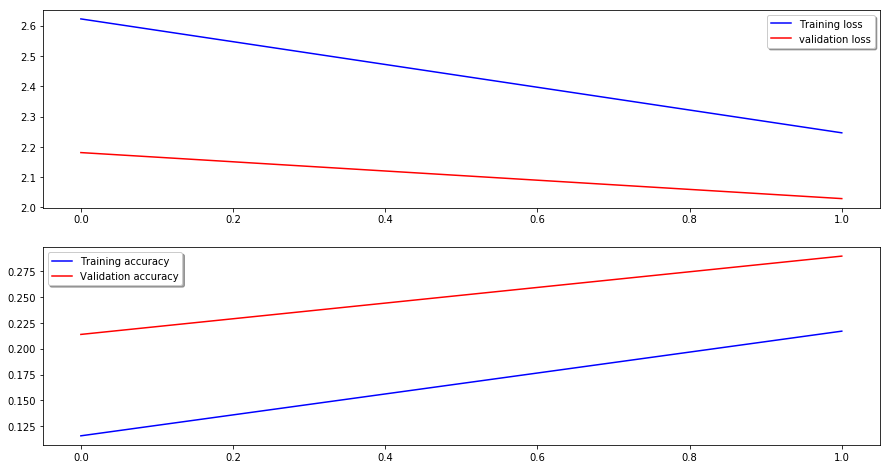

In [32]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
fig.set_figheight(8)
fig.set_figwidth(15)

The code below is for plotting loss and accuracy curves for training and validation. Below it's the training and validation curves with 55 epochs (1h23min)

<img src="./fig/CV_Classif_Plants_M1_55_epochs_learning_curves.png" alt="RGB explination" width="800"/>

The model reaches 91% accuracy on the validation dataset. The validation accuracy is greater than the training accuracy almost every time during the training. That means that our model doesn't overfit the training set.

As note, using a model with some extra filters (32, 64, 128, 128) didn't improve things as it was limited as 80% accuracy.

<img src="./fig/CV_Classif_Plants_M1_extra_filters_learning_curves.png" alt="RGB explination" width="800"/>


## 5. Prediction
### 5.1 Predict samples

In [28]:
VALIDATION_DATA = "./data/plants/validation.gz"

val_data = pd.read_csv(VALIDATION_DATA)
val_data['class'] = val_data['class'].apply(lambda x: CLASSES_DICT_NAMES[x.replace("’", "")])
val_info = val_data[['label', 'class']]
X_val = val_data.drop(labels=['label', 'class'], axis=1)

# Apply the shape required
X_val = X_val.values.reshape(-1, *RESHAPE_SIZE)
Y_val = to_categorical(val_info['class'].values, num_classes=n_unique)

##### 5.2 Confusion matrix

The confusion matrix is very helpfull to see the model drawbacks.

This is the confusion matrix on the validation results.

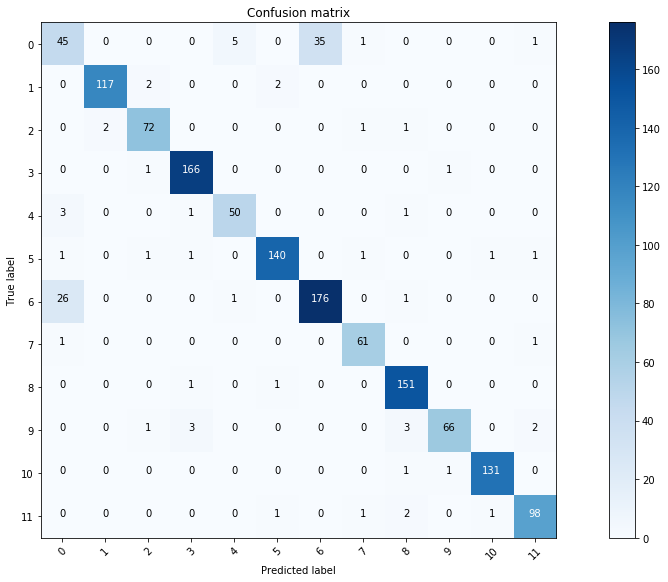

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title="Confusion matrix",
                          cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix. Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis=1) 
# compute the confusion matrix
cnf_matrix = confusion_matrix(Y_true, Y_pred_classes) 

# plot the confusion matrix
plt.figure(figsize=(15, 8))
plot_confusion_matrix(cnf_matrix, classes=range(12))

In [35]:
print(f'Accuracy: \t{accuracy_score(Y_true, Y_pred_classes):.3}')
print(f'Precision: \t{[round(k, 3) for k in precision_score(Y_true, Y_pred_classes, average=None)]}')
print(f'Recall: \t{[round(k, 3) for k in recall_score(Y_true, Y_pred_classes, average=None)]}')
print(f'F1 score: \t{[round(k, 3) for k in f1_score(Y_true, Y_pred_classes, average=None)]}')

# Or all together....
print(f'\nclasification report:\n {classification_report(Y_true, Y_pred_classes)}')

Accuracy: 	0.92
Precision: 	[0.592, 0.983, 0.935, 0.965, 0.893, 0.972, 0.834, 0.938, 0.944, 0.971, 0.985, 0.951]
Recall: 	[0.517, 0.967, 0.947, 0.988, 0.909, 0.959, 0.863, 0.968, 0.987, 0.88, 0.985, 0.951]
F1 score: 	[0.552, 0.975, 0.941, 0.976, 0.901, 0.966, 0.848, 0.953, 0.965, 0.923, 0.985, 0.951]

clasification report:
               precision    recall  f1-score   support

           0       0.59      0.52      0.55        87
           1       0.98      0.97      0.97       121
           2       0.94      0.95      0.94        76
           3       0.97      0.99      0.98       168
           4       0.89      0.91      0.90        55
           5       0.97      0.96      0.97       146
           6       0.83      0.86      0.85       204
           7       0.94      0.97      0.95        63
           8       0.94      0.99      0.96       153
           9       0.97      0.88      0.92        75
          10       0.98      0.98      0.98       133
          11       0.95  

We can see that the CNN performs very well except of the distinction between label 0 and label 6 where it accumulates the biggest amount of errors (16 in the 55 epochs model).

Let's investigate for errors.

We want to see the most important errors. For that purpose we select the biggest differences between the probabilities of the real label and the predicted labels in the results.

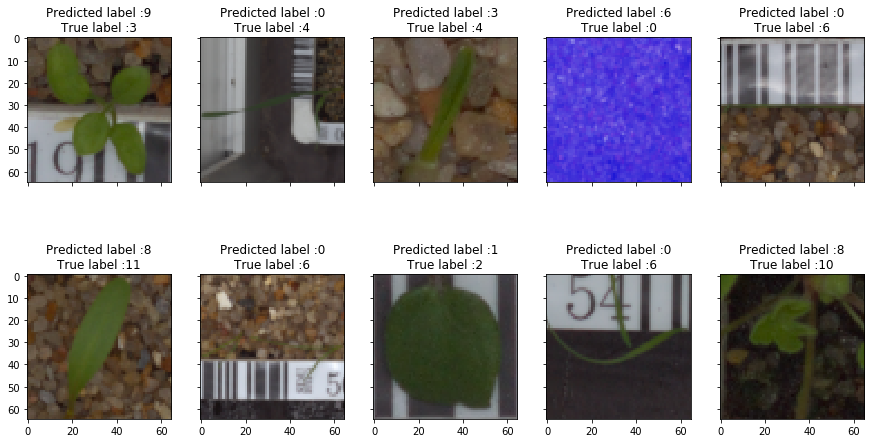

In [36]:
# Display error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors, pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row, col].imshow((img_errors[error]).reshape(RESHAPE_SIZE))
            ax[row, col].set_title(
                f"Predicted label :{pred_errors[error]}\nTrue label :{obs_errors[error]}")
            n += 1
    fig.set_figheight(8)
    fig.set_figwidth(15)

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 10 errors 
most_important_errors = sorted_dela_errors[-10:]

# Show the top 10 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

Sadly I am not expert in these plants so it's really hard to assest if these errors and justifiable or not. I'll leave it to someone expert in the area....

### Features Extraction

In [79]:
def extract_feature_layers(model, layers):
    feature_layers = []
    if isinstance(layers, str):
        layers = [layers]
    for ly in layers:
        feature_layers.append(Model(inputs=model.input, outputs=model.get_layer(ly).output))
        
    return feature_layers

layers = ["conv2d", "conv2d_1", "max_pooling2d", "conv2d_2", "conv2d_3", "max_pooling2d_1"]
feature_layers = extract_feature_layers(model, layers)

selection = np.random.randint(1000, size=9)
test_images = X_tr[selection]

In [86]:
# Get the group of filter per images and per layers
img_features = []
for img in test_images:
    new_grp = {}
    for layer_name, layer_f in zip(layers, feature_layers):
        new_grp[layer_name] = layer_f.predict(np.array([img]))[0]
    img_features.append(new_grp)

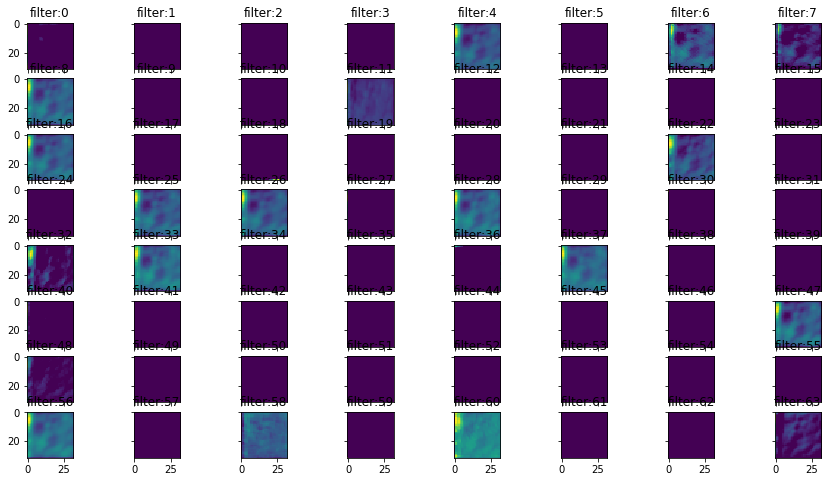

In [114]:
nrows = 8
ncols = 8
i = 0
fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
for row in range(nrows):
    for col in range(ncols):
        ax[row, col].imshow(img_features[0]["conv2d_2"][:, :, i])
        ax[row, col].set_title(
            f"filter:{i}")
        i += 1
fig.set_figheight(8)
fig.set_figwidth(15)

We can observe which filters are applied in this image and its output or checking the filters directly....

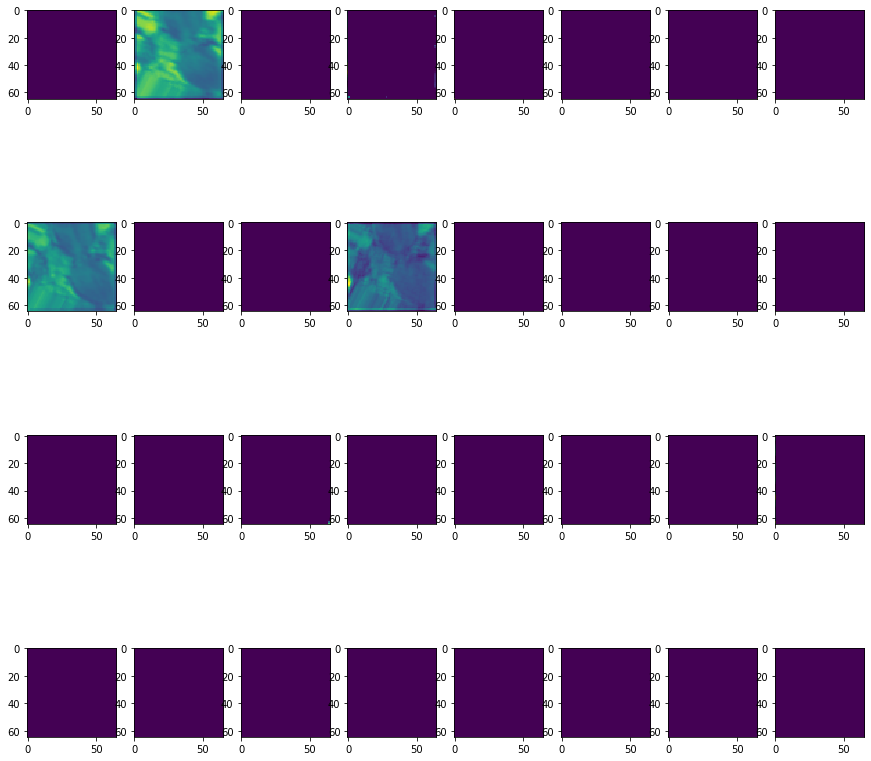

In [223]:
layer_outputs = [layer.output for layer in model.layers if not layer.name.startswith('input')]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_tr[10].reshape(1, 65, 65, 3))

def display_activation(activations, col_size, act_index): 
    activation = activations[act_index]
    n_elements = activation.shape[-1]
    n_rows = ceil(n_elements / col_size)
    activation_index = 0
    fig, ax = plt.subplots(n_rows, col_size, figsize=(n_rows*2.5, col_size*1.5))
    for row in range(n_rows):
        for col in range(0, col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index])
            activation_index += 1
    fig.set_figheight(15)
    fig.set_figwidth(15)

display_activation(activations, 8, 0)

In [29]:
# Share data with other notebook
dataset = [images_generated, labels_encoded, X_val, Y_val]
%store dataset
#del data

# Read it with
# %store -r dataset

Stored 'dataset' (list)


- [10 Pretrained Deep Learning Models](https://www.analyticsvidhya.com/blog/2018/07/top-10-pretrained-models-get-started-deep-learning-part-1-computer-vision/)
- [Pre-trained tensorflow models](https://github.com/tensorflow/models/tree/master/research/slim#pre-trained-models)
- [Understand ResNet AlexNet](https://cv-tricks.com/cnn/understand-resnet-alexnet-vgg-inception/)